In [1]:
import sys; import numpy as np; from collections.abc import Iterable

# Input data format
from calculations_file_format_single_event import return_result_dtype, Qn_species, Qn_diff_pT_cuts

result_dtype = return_result_dtype('ALICE')
data = np.fromfile('../../../../../2159949.results.dat', dtype=result_dtype)


# Examining the input
nev = len(data['ALICE'][:,0]['dNch_deta']) 
print((data['ALICE'][:,0]['dNch_deta']))
# pion = ((data['ALICE'][:,0]['mean_pT']['pion']))
# kaon = ((data['ALICE'][:,0]['mean_pT']['kaon']))
# proton = ((data['ALICE'][:,0]['mean_pT']['proton']))
# print (pion,kaon,proton)

# Note: for 2.76 TeV file use "1" for viscous correction selection index in file format, for 5.02 file use "0"

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'run_id': 'production_500pts_Pb_Pb_2760', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 324, 326, 459, 429, 334, 462, 242, 341, 406, 440, 377, 123, 447], 'npc': 10, 'MAP_obs_file': 'main.dat'}}
[ 20.83815648 951.85714286 308.52380952 ... 865.95454545 278.4
 574.44117647]


In [2]:
# Define the bin edges and centers
pT_bins = Qn_diff_pT_cuts
mid_pT_bins=[(pT_bins[i]+pT_bins[i+1])/2. for i in range(0,len(pT_bins)-1)]
pT_bins_low = np.array(np.delete(pT_bins,[0]))

# Pick out the pT-differential Qn array
Qn_diff=data['d_flow_pid']

# Pick out the pid tuples
Qn_species_no_Ch=[tmp for tmp in Qn_species if tmp[0] != "Ch"]

In [3]:
print(Qn_species_no_Ch)

[('pion', 211), ('kaon', 321), ('proton', 2212), ('Sigma', 3222), ('Xi', 3312)]


In [4]:
# Set kinematic cuts
pTminCut = .2
pTmaxCut = 3
etaCut = .5
Qn_rap_range = 2

In [5]:
# Create and fill array with Q0 values in each pT bin for the three charged particles
Q0 = np.zeros((nev,3,56))
for k in range(nev):
    for i, pT in enumerate(mid_pT_bins):
        # leave unfilled the bins outside pT cut
        if (pT<pTminCut or pT>pTmaxCut):
            continue
        Q0[k][0][i] = Qn_diff['pion']['N'][k][:,i][0]
        Q0[k][1][i] = Qn_diff['kaon']['N'][k][:,i][0]
        Q0[k][2][i] = Qn_diff['proton']['N'][k][:,i][0]

In [6]:
# Scale Q0 by bin pT and sum bins for each event for the three charged particles

pion_diff = np.zeros(nev); kaon_diff = np.zeros(nev); proton_diff = np.zeros(nev);
nbins = len(mid_pT_bins)

for k in range(nev):
    pi_sum = np.zeros(nbins); k_sum = np.zeros(nbins); p_sum = np.zeros(nbins);  
    #weight=1
    pi = Q0[k][0][:]; ka = Q0[k][1][:]; p = Q0[k][2][:]
    temp_pi = mid_pT_bins*pi
    pion_diff[k] = (np.sum(temp_pi))/(np.sum(pi))
    temp_k = mid_pT_bins*ka
    kaon_diff[k] = (np.sum(temp_k))/(np.sum(ka))
    temp_p = mid_pT_bins*p
    proton_diff[k] = (np.sum(temp_p))/(np.sum(p))

In [7]:
print(pion_diff)
print(kaon_diff)

[0.51623038 0.61351059 0.58154044 ... 0.601685   0.59000544 0.63043893]
[0.66729425 0.87332998 0.80477737 ... 0.85664104 0.81057278 0.89963719]


In [8]:
# Sort the mean pT event-arrays by the charged particle multiplicity in descending order
pion = np.zeros(nev); kaon = np.zeros(nev); proton = np.zeros(nev); Nch = np.zeros(nev)

sort = np.array(sorted(range(nev), key = lambda x: data['ALICE'][:,0]['dNch_deta'][x], reverse=True))
for i in range(nev):

        # Pre-calculated <pT> for full pT range (0-10 MeV)
    #pion[i] = data['ALICE'][:,0]['mean_pT']['pion'][sort[i]]
    #kaon[i] = data['ALICE'][:,0]['mean_pT']['kaon'][sort[i]]
    #proton[i] = data['ALICE'][:,0]['mean_pT']['proton'][sort[i]]
    
        # <pT> using pT-differential Q0s as calculated in this script
    pion[i] = pion_diff[sort[i]]
    kaon[i] = kaon_diff[sort[i]]
    proton[i] = proton_diff[sort[i]]
    
        # sorted charged multiplicity
    Nch[i] = data['ALICE'][:,0]['dNch_deta'][sort[i]]
    
# see the sorted charged multiplicity and the ordered indeces based on the unsorted array
#for i in range(4835): print (i,data['ALICE'][:,0]['dNch_deta'][i],Nch[i],sort[i])

In [9]:
# Bin the <pT> and average over events in each centrality bin 
    # ALICE centrality bins
cen = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]])
    # event number bin thresholds
index = (cen/100.*nev).astype(int)
    # centrality bin centers
cenM = np.mean(cen, axis=1)

mean_pT = np.zeros((3,len(cenM)))
for i, (nl,nh) in enumerate(zip(index[:,0], index[:,1])):
    x = pion[nl:nh]; y = kaon[nl:nh]; z = proton[nl:nh]
    mean_pT[0][i] = np.mean(x); mean_pT[1][i] = np.mean(y); mean_pT[2][i] = np.mean(z)

#for i in range(len(cenM)): print(cen[i],index[i],cenM[i])

In [10]:
# Approximation using the upper pT-bin edges to scale the Q0 instead of the bin centers 
mean_pT_upper_cutoff = np.array([[0.55536585, 0.55145251, 0.54619028, 0.53631329, 0.52230146,
        0.50643578, 0.4883417 , 0.4720518 ],
       [0.87901957, 0.8694625 , 0.85705645, 0.83498001, 0.80532596,
        0.77279689, 0.73559601, 0.7014962 ],
       [1.44108016, 1.42282725, 1.39579757, 1.35302867, 1.29546323,
        1.23501775, 1.16505102, 1.09747884]])

In [11]:
# Pre-calculated (integrated) <pT> 
int_mean_pT2 = np.array([[0.52871837, 0.52518634, 0.51972261, 0.50986828, 0.49581644,
        0.47998804, 0.46194116, 0.44552806],
       [0.85301246, 0.8438506 , 0.83107432, 0.80907297, 0.77954982,
        0.74773423, 0.71046434, 0.67636516],
       [1.40092261, 1.38578772, 1.35895242, 1.31905084, 1.26365088,
        1.20569498, 1.135085  , 1.06886502]])

In [12]:
# pT-differential calculation for [0.15,2 GeV] 
mean_pT_015_2 = np.array([[0.57782373, 0.57477733, 0.57060155, 0.56215582, 0.54992032,
        0.5354695 , 0.51863575, 0.50289536],
       [0.83522273, 0.82779592, 0.81866868, 0.8018787 , 0.77845065,
        0.75205946, 0.72036283, 0.68983296],
       [1.16369697, 1.15756769, 1.14732843, 1.12936993, 1.10355664,
        1.07342663, 1.03486038, 0.99217278]])

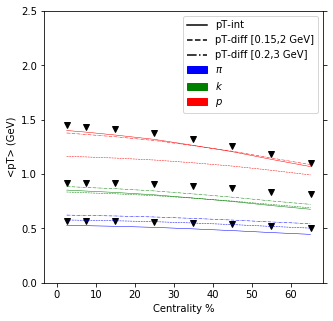

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data_pi = [.5682,.5711,.5704,.5615,.5525,.5389,.5214,.5082]
data_k = [.9177,.9214,.9193,.9052,.8919,.8685,.8369,.8165]
data_p = [1.4482,1.4334,1.4143,1.3768,1.3209,1.2570,1.1822,1.1004]

ax = plt.subplot(111)
#plt.rcParams.update({'linewidth': 10})
plt.rcParams["figure.figsize"] = [5, 5]
ax.set_ylim(ymin=0, ymax=2.5);

    # experimental data
plt.plot(cenM,data_pi,'kv')
plt.plot(cenM,data_k,'kv')
plt.plot(cenM,data_p,'kv')

    # pT-differential calculation using the cuts set in this script
plt.plot(cenM,mean_pT[0],'-.b', linewidth=.5)
plt.plot(cenM,mean_pT[1],'-.g', linewidth=.5)
plt.plot(cenM,mean_pT[2],'-.r', linewidth=.5)
    
    # pT-differential calculation for [0.15,2 GeV] 
plt.plot(cenM,mean_pT_015_2[0],'--b', linewidth=.5)
plt.plot(cenM,mean_pT_015_2[1],'--g', linewidth=.5)
plt.plot(cenM,mean_pT_015_2[2],'--r', linewidth=.5)

    # Pre-calculated (integrated) <pT>     
plt.plot(cenM,int_mean_pT2[0],'b', linewidth=.5)
plt.plot(cenM,int_mean_pT2[1],'g', linewidth=.5)
plt.plot(cenM,int_mean_pT2[2],'r', linewidth=.5)

    # Range for <pT> using the upper bin edge as the highest deviation
#ax.fill_between(cenM, mean_pT[0]-(mean_pT_upper_cutoff[0]-mean_pT[0]), mean_pT[0]+(mean_pT_upper_cutoff[0]-mean_pT[0]),
    #alpha=0.5, facecolor='cornflowerblue', linestyle='dashdot')  #edgecolor='#008000','#15B01A'
#ax.fill_between(cenM, mean_pT[1]-(mean_pT_upper_cutoff[1]-mean_pT[1]), mean_pT[1]+(mean_pT_upper_cutoff[1]-mean_pT[1]),
    #alpha=0.5, facecolor='mediumaquamarine', linestyle='dashdot')  #edgecolor='#008000','#15B01A'
#ax.fill_between(cenM, mean_pT[2]-(mean_pT_upper_cutoff[2]-mean_pT[2]), mean_pT[2]+(mean_pT_upper_cutoff[2]-mean_pT[2]),
    #alpha=0.5, facecolor='indianred', linestyle='dashdot')  #edgecolor='#008000','#15B01A'


w, = plt.plot(0,0,'--k', label='pT-diff [0.15,2 GeV]');
w2, = plt.plot( 0,0 ,'k', label='pT-int');
w3, = plt.plot(0,0,'-.k', label="pT-diff [0.2,3 GeV]")
blue_patch = mpatches.Patch(color='blue', label='$\pi$');
green_patch = mpatches.Patch(color='green', label='$k$');
red_patch = mpatches.Patch(color='red', label='$p$');
plt.legend(handles=[w2,w,w3,blue_patch,green_patch,red_patch])

plt.xlabel('Centrality %')
plt.ylabel('<pT> (GeV)')
ax.yaxis.tick_left()
ax.yaxis.set_ticks_position('both')
plt.savefig('meanpT.png', bbox_inches='tight', dpi=300)
plt.show()